# Неделя Трансформеров: День 5. Energy-based, Основано на реальной термодинамике

Ну вот и рабочая неделя подошла к концу. Поскольку за эти выходные надо наверстать все упущенное летом, опубликую еще один бонусный пост с планами и размышлениями. 

Итак, еще одно интересное направление, откуда можно черпать идеи для ML - физика (в данном случае - термодинамика).

Мотивация авторов статьи опять-таки исходит из психологии (Daniel Kahneman. Thinking, fast and slow): существует System 1 - "Быстрое" мышление для оперативных задач и System 2 - "Медленное мышление" для стратегических задач. 

Чем-то напоминает память GPU, о которой мы говорили вчера.

В то время как трансформеры хорошо справляются с задачами System 1, второй класс задач дается им с большим трудом. В рассматриваемой сегодня статье для преодоления этой сложности используют функцию энергии из термодинамики.

На тему System 1 и 2 недавно вышла статья Hierarchical Reasoning Model https://arxiv.org/abs/2506.217341 , которая подходит к этой проблеме через рекуррентные нейронные сети, и с обзором которой я выступлю 11.09.2025. Материалы к выступлению также постараюсь выложить на Гитхаб!


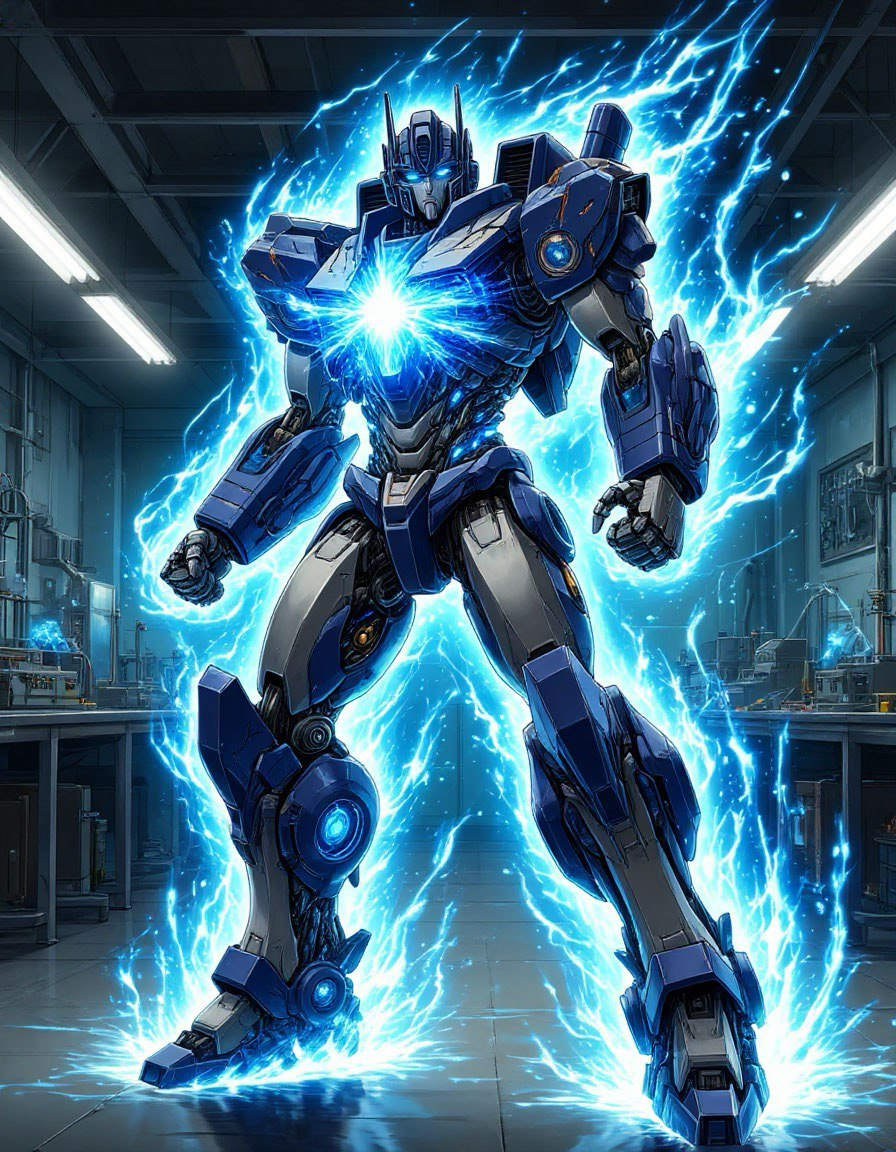

In [3]:
from IPython.display import Image
Image('5_Title.jpg', width=300, height=150 )


Сегодняшняя статья подготовлена коллективом авторов из 
Университетов 

    University of Illinois Urbana-Champaign

    University of Amsterdam

    Stanford University

    Harvard University

и научного подразделения одной небольшой компании 

    Amazon GenAI

# Energy-Based Transformers are Scalable Learners and Thinkers ( 2 Jul 2025) https://arxiv.org/abs/2507.02092

Код на гитхаб 1. https://energy-based-transformers.github.io/ 2. https://github.com/alexiglad/ebt

Авторы статьи задаются вопросом:
“Is it possible to generalize these System 2 Thinking approaches, and develop models
that learn to think solely from unsupervised learning?” И отвечают на него **yes**.

Более общая формулировка: можем мы обучить модель, которая может придумывать решения к новым поступающим задачам, обучив ее только с учителем (есть вопрос и ответ на него, функция потерь штрафует за неправильные ответы).

Ну и глобальльная цель авторов - научить модель проверять свои ответы и понимать, что она вообще делает.

Предложенный ими метод состоит в том, чтобы "верифицировать" соответствие данных, подаваемых модели на вход, и ее ответов на выходе, а затем решить задачу оптимизации для функции, по которой мы "верифицировали". В данной статье авторы используют энергию (ненормализованную вероятность) для даных на входе и кандидатов на статус ответа. По сути, уже существует  целый класс моделей с похожей идеей Energy-Based Models (EBMs), который аторы расширили своими Energy-Based Transformers (EBTs).


По сути, авторы используют в качестве функции потерь (которую мы минимизируем в процессе обучения) функцию энергии $E_\theta(x, y_i)$, возвращающей скаляр. Обновление параметров происходит по стандартной формуле 



Особенности архитектуры своего трансформера авторы описали в п. 3. Поскольку описание достаточно громоздкое, философское в плане интерпретации в рамках System 1 и System 2, и без формул, быстро пробежимся по каждому пункту.

3.1. В EBMs, на которых основывались разработки, для моделирования было выбрано распределение Больцмана. Поэтому меньшей энергии соответствует большая вероятность. 

3.2. Процесс обучения состоит из двух шагов: сначала вычисляется оптимизация ответа $y_{i+1} = y_i − α∇y_i E_θ (x, y_i)$, затем вторым шагом происходит стандартный прием обучения моделей - градиентный спуск. Из-за этого приходится вычислять градиенты второго порядка, что резко повышает необходимое количество вычислений.

3.3. Чтобы регуляризировать (снизить амплитуду параметров) процесс обучения, авторы использовали комбинацию из трех техник.  

3.4. Cвой подход авторы применили и к decoder и encoder-онли архитектурам.


# Плюсы и минусы

✅ Плюсы 

1. System 2 / «Мышление»: Главное нововведение. Модель может «думать» над ответом, итеративно улучшая его через внутренний цикл оптимизации (градиентный спуск по энергии), что приводит к более точным и обдуманным предсказаниям.

2. Улучшенная масштабируемость: Авторы заявляют, что EBT демонстрируют на 35% лучшую эффективность (на параметрах, данных и FLOPs) по сравнению с обычными трансформерами, то есть при одинаковых ресурсах показывают лучшее качество.

3. Лучшее обобщение (OOD): Благодаря энергетическому подходу модель лучше справляется с данными, сильно отличающимися от обучающих (out-of-distribution), так как может оценивать правдоподобность ответа через энергию.

4. Встроенная проверка (Self-Verification): Модель сама вычисляет энергию итогового ответа, что дает меру уверенности в своем предсказании. Низкая энергия = высокая уверенность.

5. Универсальность (Modality-Agnostic): Одна и та же архитектурная идея применяется к разным модальностям (текст, изображения) без фундаментальных изменений.

❌ Минусы (Проблемы и Компромиссы)

1. Вычислительная стоимость инференса: Генерация ответа требует множества шагов градиентного спуска, что намного медленнее, чем один прямой проход (forward pass) в обычном трансформере. Это жертва скоростью ради качества.

2. Сложность обучения: Процесс обучения с использованием контрастивтивных методов и градиентов второго порядка более сложен, нестабилен и требует тщательной настройки (регуляризация, планировщики и т.д.).

3. Проблема инициализации: Качество итогового ответа y* может сильно зависеть от начальной случайной инициализации y0. Плохой старт может привести к попаданию в локальный минимум.

4. Интерпретируемость: Хотя энергия дает меру уверенности, сам процесс «мышления» модели (изменение внутреннего состояния y) может быть сложным для интерпретации человеком.

---

🎯 Итог в двух предложениях:

EBT — это мощный шаг вперед в плане качества, обобщения и получения «думающих» моделей, но он достигается за счет кардинального увеличения вычислительных затрат на инференс и сложности обучения. Этот подход меняет парадигму с «быстрого ответа» на «медленное и обдуманное решение».

# Полезные ссылки

Больше про термодинамику и ML в целом!
https://rutube.ru/video/fae00848ed6c4f70cd869c005227feb8/

[Literature Review] Energy-Based Transformers are Scalable Learners and Thinkers https://www.themoonlight.io/en/review/energy-based-transformers-are-scalable-learners-and-thinkers

Daniel Kahneman. Thinking, fast and slow. 
https://dn790002.ca.archive.org/0/items/DanielKahnemanThinkingFastAndSlow/Daniel%20Kahneman-Thinking%2C%20Fast%20and%20Slow%20%20.pdf